In [177]:
using ADAS
impurities = [:Kr,:W,:Ar,:Ne,:C]
Lz = [ADAS.get_cooling_rates(imp) for imp in impurities];
Rrad = [ADAS.get_radiation_rates(imp) for imp in impurities];

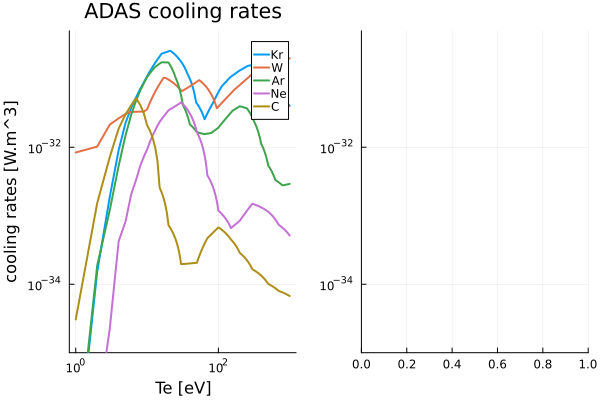

In [178]:
using Plots
plot(layout=2)
for Lz_ in Lz
plot!(Lz_, Te=LinRange(1.0,1000.0,1000),ylim=[1e-35,5e-31], yscale=:log10, layout=1) 
end

plot!()


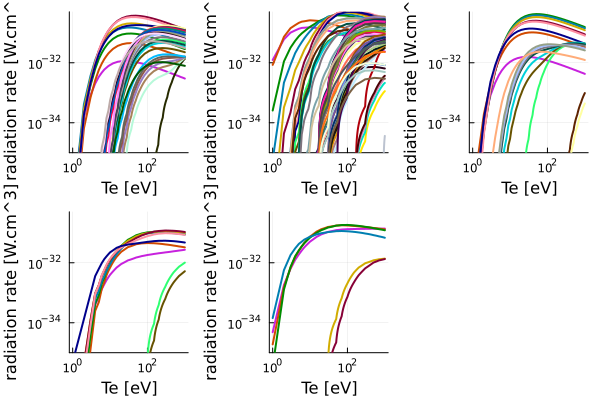

In [181]:
using Plots
plot(layout=length(Rrad))
for (i,Rrad_) in enumerate(Rrad)
    plot!(Rrad_, Te=LinRange(1.0, 1000.0, 1000), ylim=[1e-35, 5e-31], yscale=:log10, subplot=i, legend=nothing)
end
plot!()

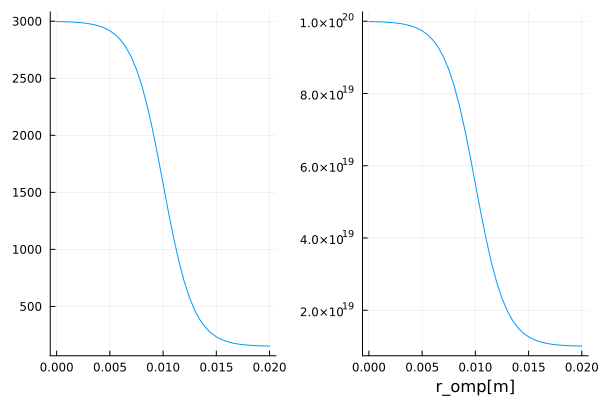

In [182]:
r_omp = 0.0:0.0005:0.02
_f(ξ, fmin, fmax; α=1.0, β=0.0) = @. (fmax + fmin) / 2.0 + tanh(α * ξ + β) * (fmax - fmin) / 2.0
fξ(x) = (x .- minimum(x)) ./ (maximum(x) - minimum(x)) .- 0.5
f(x,args...; kw...) = _f(fξ(x),args...; kw...)
Te_ped = 3000.0
Te_sep = 150.0
ne_ped = 1e20
ne_sep = 1e19
Te = f(r_omp,Te_ped,Te_sep,α=7.0)
ne = f(r_omp, ne_ped, ne_sep, α=7.0)
plot(layout=2)
plot!(r_omp, Te, subplot=1, label=nothing)
plot!(r_omp,ne,subplot=2, label=nothing, xlabel="r_omp[m]")

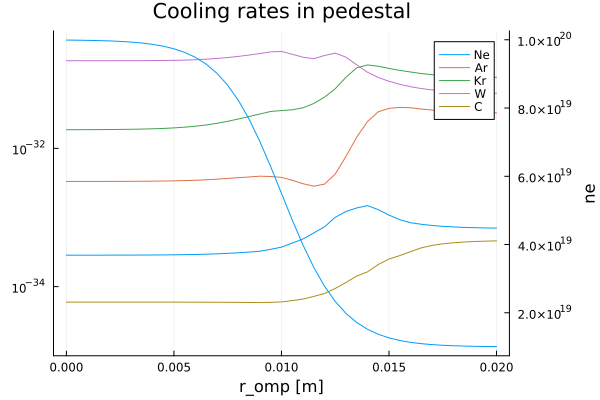

In [195]:

Lztot = Dict(Lz_.imp => [Lz_.Lztot(ne_, Te_) for (Te_, ne_) in zip(Te, ne)] for Lz_ in Lz)
Pvol_rad = Dict(Lz_.imp => [Lz_.Lztot(ne_, Te_) * ne_^2 for (Te_, ne_) in zip(Te, ne)] for Lz_ in Lz)


plot(title="Cooling rates in pedestal")
for (k,v) in Lztot
    plot!(r_omp, v, ylim=[1e-35, 5e-31], yscale=:log10, xlabel="r_omp [m]", label="$k")
end
plot!(twinx(),r_omp, ne, label=nothing, ylabel="ne")
plot!()

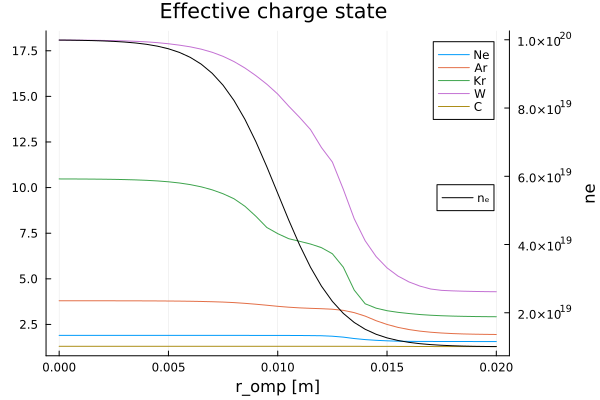

In [216]:
eff_Z = Dict(Lz_.imp => [ADAS.get_effective_charge(Lz_.imp)(0.01,ne_,Te_) for (Te_, ne_) in zip(Te, ne)] for Lz_ in Lz)


plot(title="Effective charge state ")
for (k, v) in eff_Z
    plot!(r_omp, v, xlabel="r_omp [m]", label="$k")
end
plot!(twinx(), r_omp, ne, ylabel="ne", color=:black, label = "nₑ", legendposition=:right)
plot!()

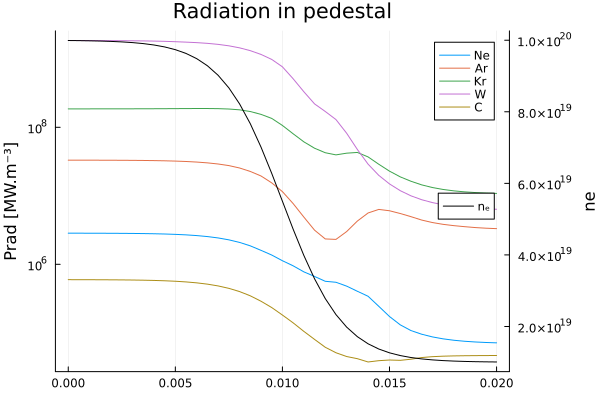

In [218]:
plot(title="Radiation in pedestal")

for (k,v) in Pvol_rad
plot!(r_omp,v, label="$k", ylabel = "Prad [MW.m⁻³]", yscale=:log10)
end
plot!(twinx(), r_omp, ne, ylabel="ne", color=:black, label="nₑ", legendposition=:right)
plot!()

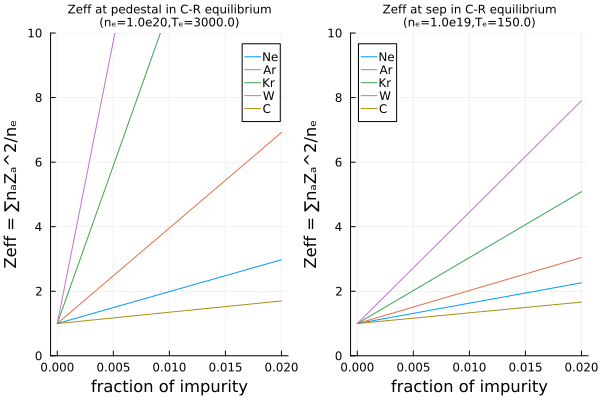

In [194]:
using NumericalIntegration
Prad_tot = Dict(k => NumericalIntegration.integrate(r_omp, v) for (k, v) in Pvol_rad)
fraction_imp = 0.0:0.0025:0.02
Zeff_ped = Dict( imp => [ADAS.get_Zeff(imp)(f,ne_ped,Te_ped) for f in fraction_imp] for imp in impurities)
Zeff = Dict(imp => ADAS.get_Zeff(imp) for imp in impurities)
Zeff_sep = Dict(imp => [ADAS.get_Zeff(imp)(f, ne_sep, Te_sep) for f in fraction_imp] for imp in impurities)
plot(layout=2)
plot!(title="Zeff at pedestal in C-R equilibrium\n (nₑ=$ne_ped,Tₑ=$Te_ped) ", subplot=1, titlefontsize=8)
for (k,v) in Zeff_ped
    plot!(fraction_imp,v, label="$k", subplot=1)
end

plot!(xlabel="fraction of impurity", ylabel="Zeff = ∑nₐZₐ^2/nₑ", subplot=1, ylim=[0, 10])

plot!(title="Zeff at sep in C-R equilibrium\n (nₑ=$ne_sep,Tₑ=$Te_sep) ", subplot=2, titlefontsize=8)
for (k, v) in Zeff_sep
    plot!(fraction_imp, v, label="$k", subplot=2)
end

plot!(xlabel="fraction of impurity", ylabel="Zeff = ∑nₐZₐ²/nₑ", subplot=2, ylim=[0,10])


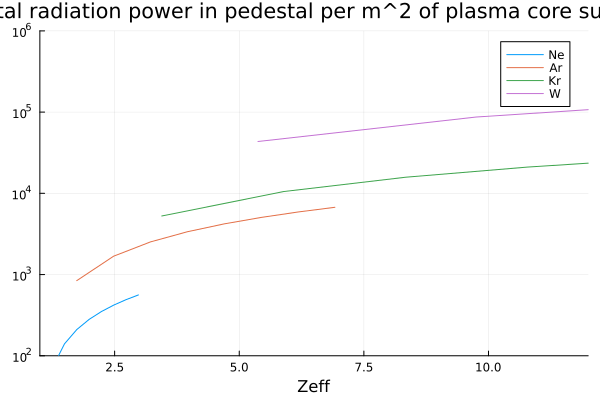

In [142]:
plot(title="Total radiation power in pedestal per m^2 of plasma core surface")
for (k, v) in Prad_tot
    plot!(Zeff_ped[k], v * fraction_imp, label="$k")
end
plot!(xlim=[1.0,12],xlabel= "Zeff", ylim=[1e2,1e6],yscale=:log10)

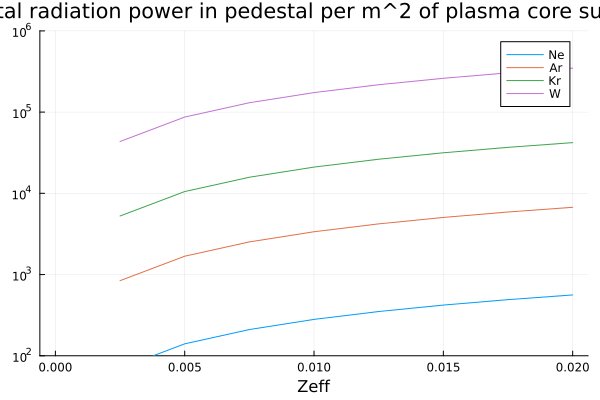

In [143]:
plot(title="Total radiation power in pedestal per m^2 of plasma core surface")
for (k, v) in Prad_tot
    plot!(fraction_imp, v * fraction_imp, label="$k")
end
plot!( xlabel="Zeff", ylim=[1e2, 1e6], yscale=:log10)

In [136]:
plot()
for (k, v) in Pvol_rad
    plot!(Zeff_ped[k], Pvol_rad[k], label="$k")
end
plot!()
Pvol_rad[:Kr]

41-element Vector{Float64}:
 1.8570617016327763e8
 1.857336575575757e8
 1.857723380748695e8
 1.858265746076599e8
 1.8590223099494886e8
 1.860069780869203e8
 1.8615041701532766e8
 1.8634365701864696e8
 1.8659759458195803e8
 1.8691843111131188e8
 ⋮
 1.6316999731525125e7
 1.4451300594512282e7
 1.3215182427111119e7
 1.2382648744893253e7
 1.1814928312269332e7
 1.142420865429989e7
 1.1153490154820032e7
 1.0965002151497161e7
 1.083330808831973e7

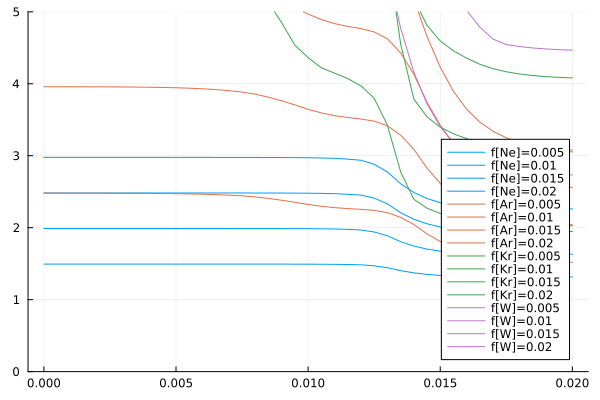

In [162]:
plot()
    for (i,(k,v)) in enumerate(Zeff)
        for f in 0.005:0.005:0.02
        Zeff_ = [v(f,ne_, Te_) for (Te_, ne_) in zip(Te, ne)]
        plot!(r_omp,Zeff_,label="f[$(k)]=$f",color=i)
    end
end

plot!(ylim=[0,5])

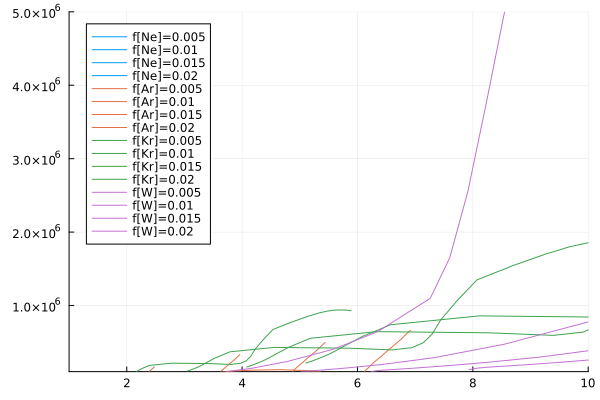

In [171]:
plot()

for (i, (k, v)) in enumerate(Zeff)
    for f in 0.005:0.005:0.02
        Zeff_ = [v(f, ne_, Te_) for (Te_, ne_) in zip(Te, ne)]
        plot!(Zeff_,f*Pvol_rad[k], label="f[$(k)]=$f", color=i)
    end
end
plot!(xlim=[1,10],ylim=[1e5,5e6])
